# Dynamics Programming Introduction

@[Chaoming Wang](https://github.com/chaoming0625)

> What I cannot create, I do not understand.   --- Richard Feynman

Brain is a complex dynamical system. In order to simulate it, we provide [brainpy.DynamicalSystem](../apis/building/generated/brainpy.building.brainobjects.DynamicalSystem.rst). ``brainpy.DynamicalSystem`` can be used to define any brain objects which have dynamics. Various children classes are implemented to model these brain elements, such like: [brainpy.NeuGroup](../apis/building/generated/brainpy.building.brainobjects.NeuGroup.rst) for neuron groups, [brainpy.TwoEndConn](../apis/building/generated/brainpy.building.brainobjects.TwoEndConn.rst) for synaptic computations, [brainpy.Network](../apis/building/generated/brainpy.building.brainobjects.Network.rst) for network modelings, etc. Arbitrary composition of these objects is also an instance of ``brainpy.DynamicalSystem``. Therefore, ``brainpy.DynamicalSystem`` is the universal language to define dynamical models in BrainPy. 

In [1]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')

## ``brainpy.DynamicalSystem``

In this section, let's try to understand the mechanism and the function of ``brainpy.DynamicalSystem``. 

Intuitively, a `dynamical system` is a system which has the time-dependent state. 

Mathematically, it can be expressed as

$$
\dot{X} = f(X, t)
$$

where $X$ is the state of the system, $t$ is the time, and $f$ is a function describes the time dependence of the system state. 

Alternatively, the evolution of the system along the time can be given by

$$
X(t+dt) = F\left(X(t), t, dt\right)
$$

where $dt$ is the time step, and $F$ is the evolution rule to update the system's state.

Accordingly, in BrainPy, any subclass of ``brainpy.DynamicalSystem`` must implement this updating rule in the *update* function (``def update(self, _t, _dt)``), like

In [2]:
class YourDynamicalSystem(bp.DynamicalSystem):
    
    def update(self, _t, _dt):
        pass

BrainPy has rich support for ``brainpy.DynamicalSystem``, including:

- flexible interfaces to **define** various brain objects,
- JIT compilation for efficient **simulation**,
- automatic **analysis** for phase plane, bifurcation, linearization and more,
- easy workflow to **train** a dynamical system from data or tasks.

In below, let's see how to use these supports. 

##  Dynamical System Building

Defining a dynamical system in BrainPy is easy and flexible. Here, we illustrate this by using the well known [FitzHugh–Nagumo neuron model](https://brainmodels.readthedocs.io/en/latest/apis/generated/brainmodels.neurons.FHN.html), whose dynamics is given by: 

$$
{\dot {v}}=v-{\frac {v^{3}}{3}}-w+I, \\
\tau {\dot {w}}=v+a-bw.
$$

This model contains two differential equations. In BrainPy, the numerical integration of ordinary differential equations can be accomplished with [brainpy.odeint](../apis/integrators/generated/brainpy.integrators.odeint.rst) (the details please see the tutorials in [Numerical Integrator](../tutorial_intg/index.rst)). 

According to the coding paradigm of BrainPy integrators, we can define the above two differential equations as Python functions like:

In [3]:
def dV(V, t, w, Iext=0.): 
    return V - V * V * V / 3 - w + Iext
    
def dw(w, t, V, a=0.7, b=0.8): 
    return (V + a - b * w) / self.tau

where ``t`` is the time variable, arguments before ``t`` are variables, while arguments after ``t`` are parameters.

Thereafter, the numerical solvers for above two equations can be defined as:

In [4]:
int_V = bp.odeint(dV, method='euler')

int_w = bp.odeint(dw, method='euler')

in which ``method`` can be used to select the numerical integration methods (all implemented methods can be checked in the tutorial of [Numerical Solvers for ODEs](../tutorial_intg/ode_numerical_solvers.ipynb)). 

Based on the numerical integrators, we can define FitzHugh–Nagumo neuron model as a Python class, in which the constructor (``__init__()`` function) can be used to define parameters, variables, and integral functions, and the update function (``update()``) can be used to define the transition rule of model from the current time $\mathrm{\_t}$ to the next time $\mathrm{\_t + \_dt}$.

In [5]:
class FitzHughNagumoModel(bp.DynamicalSystem):
  def __init__(self, num, method='exp_auto'):
    super(FitzHughNagumoModel, self).__init__()

    # parameters
    self.a = 0.7
    self.b = 0.8
    self.tau = 12.5

    # variables
    self.V = bm.Variable(bm.zeros(num))
    self.w = bm.Variable(bm.zeros(num))
    self.Iext = bm.Variable(bm.zeros(num))  # used to receive the external input

    # functions
    def dV(V, t, w, Iext=0.): 
        return V - V * V * V / 3 - w + Iext
    def dw(w, t, V, a=0.7, b=0.8): 
        return (V + a - b * w) / self.tau
    self.int_V = bp.odeint(dV, method=method)
    self.int_w = bp.odeint(dw, method=method)

  def update(self, _t, _dt):
    self.V.value = self.int_V(self.V, _t, self.w, self.Iext, _dt)
    self.w.value = self.int_w(self.w, _t, self.V, self.a, self.b, _dt)
    self.Iext[:] = 0.

In [6]:
fhn = FitzHughNagumoModel(2)

In BrainPy, any dynamical model can be defined as a Python class. More advanced usage of dynamical system building can be obtained in the dedicated tutorials in [Dynamics Building](../tutorial_building/index.rst).

##  Dynamical System Simulation

Dynamics simulation in BrainPy is highly efficient. It can deploy models into CPUs or GPUs. To switch the backend device, you can use ``brainpy.math.set_platform("cpu" or "gpu")`` at the top of your script. 

Currently, BrainPy provides several [runners](../apis/auto/simulation/runner.rst) to satisfy your different simulation purposes. For example, if you want to get the compelling simulation performce, you can use ``brainpy.StructRunner``. If you are trying to debug your codes using the standard Python debugging tools, you can use ``brainpy.ReportRunner``. Almost all runners have the same interface. For example, they all support **monitoring** variable trajectories, and giving **inputs** to target variables during a simulation. 

Here, we use ``brainpy.StructRunner`` to run the above instance ``fhn``. During the running, we monitor variables ``V`` and ``w``, and give inputs to ``Iext`` variable (the details of how to define monitors and inputs can be seen in the tutorial of [Monitors and Inputs](../tutorial_simulation/monitors_and_inputs.ipynb)). 

In [7]:
runner = bp.StructRunner(fhn, monitors=['V', 'w'], inputs=['Iext', 1.])
runner.run(100.)

0.12299966812133789

The recoreded variable values are defined in ``runner.mon``:

In [8]:
runner.mon

We visualize the the monitoring results turough [brainpy.visualize](../apis/auto/visualization.rst) module.

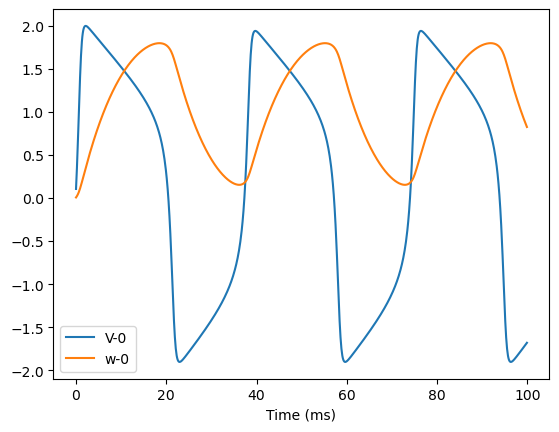

In [9]:
bp.visualize.line_plot(runner.mon.ts, runner.mon['V'], legend='V')
bp.visualize.line_plot(runner.mon.ts, runner.mon['w'], legend='w', show=True)

In above we illustrate how to simulate a simple FitzHugh-Nagumo model. However, more details of dynamical system simulation can be obtained through the tutorials in [Dynamics Simulation](../tutorial_simulation/index.rst).

##  Dynamical System Analysis

In BrainPy, the defined model can not only be used for simulation, but also to perform automatic dynamics analysis. 

BrainPy provides rich interfaces to support analysis, incluing

- phase plane analysis, bifurcation analysis, and fast-slow bifurcation analysis for [low-dimensional systems](../tutorial_analysis/lowdim_analysis.ipynb);
- linearization analysis and fixed/slow point finding for [high-dimensional systems](../tutorial_analysis/highdim_analysis.ipynb). 

For the above FitzHugh-Nagumo model, it is a two variable model. We can use [brainpy.analysis.PhasePlane2D](../apis/auto/analysis/generated/brainpy.analysis.lowdim.PhasePlane2D.rst) to make phase plane analysis. 

In [11]:
bp.math.enable_x64()

I am computing fx-nullcline ...
I am evaluating fx-nullcline by optimization ...
I am computing fy-nullcline ...
I am evaluating fy-nullcline by optimization ...
I am creating vector fields ...
I am searching fixed points ...
I am trying to find fixed points by optimization ...
	There are 866 candidates
I am trying to filter out duplicate fixed points ...
	Found 1 fixed points.
	#1 V=-0.2738719079879798, w=0.5329731346879486 is a unstable node.
I am plot trajectory ...


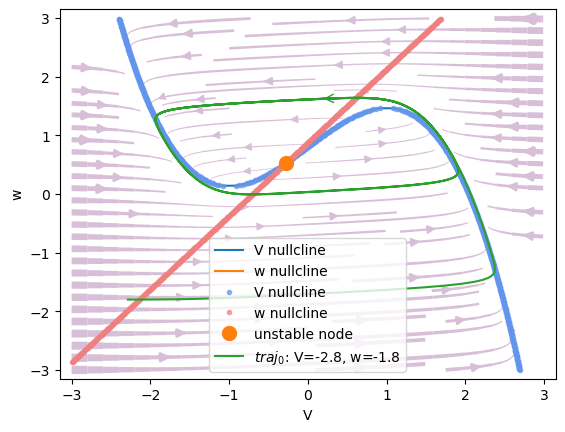

In [12]:
analyzer = bp.analysis.PhasePlane2D(
  fhn,
  target_vars={'V': [-3, 3], 'w': [-3., 3.]},
  pars_update={'Iext': 0.8}, 
  resolutions=0.01,
)
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory({'V': [-2.8], 'w': [-1.8]}, duration=100.)
analyzer.show_figure()

To find more tools for dynamics analysis, you can refer to the tutorials in [Dynamics Analysis](../tutorial_analysis/index.rst) and examples in [BrainPy-Examples](https://brainpy-examples.readthedocs.io/en/brainpy-2.x/dynamics_analysis/index.html).

##  Dynamical System Training

In recent years, we saw the revolution that training a dynamical system from data or tasks has provided important insights to understand brain functions. To support this, BrainPy porvides various interfaces to help users train dynamical systems. 

Examples of using FORCE learning algorithm, back-propagation algorithm or others to train recurrent neural networks can be found in [BrainPy-Examples](https://brainpy-examples.readthedocs.io/en/brainpy-2.x/recurrent_networks/index.html). 